In [1]:
import os
import requests
import json
import time
import re

import pandas as pd
import polyline
import matplotlib.pyplot as plt

In [2]:
TOKENS_FILEPATH = os.getenv("TOKENS_FILEPATH")
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

In [3]:
def get_tokens(client_id, client_secret, tokens_filepath):
    """ Gets the Strava tokens from a json file and refreshes them if expired """
    
    # Get the tokens from file to connect to Strava
    with open(tokens_filepath) as json_file:
        strava_tokens = json.load(json_file)

    # If access_token has expired then use the refresh_token to get the new access_token
    if strava_tokens['expires_at'] < time.time():

        #Make Strava auth API call with current refresh token
        response = requests.post(
                            url = 'https://www.strava.com/oauth/token',
                            data = {
                                    'client_id': int(client_id),
                                    'client_secret': client_secret,
                                    'grant_type': 'refresh_token',
                                    'refresh_token': strava_tokens['refresh_token']
                                    }
                        )

        #Save response as json in new variable
        new_strava_tokens = response.json()

        # Save new tokens to file
        with open(tokens_filepath, 'w') as outfile:
            json.dump(new_strava_tokens, outfile)

        #Use new Strava tokens from now
        strava_tokens = new_strava_tokens 
    
    return strava_tokens

In [4]:
strava_tokens = get_tokens(CLIENT_ID, CLIENT_SECRET, TOKENS_FILEPATH)

In [5]:
def plot_polyline(summary_polyline):
    """ Plots a segment or a route from a polyline object """

    coordinates = polyline.decode(summary_polyline)

    ride_longitudes = [coordinate[1] for coordinate in coordinates]
    ride_latitudes = [coordinate[0] for coordinate in coordinates]

    plt.plot(ride_longitudes, ride_latitudes, 'r-', alpha=1)
    plt.show()

In [6]:
# Loop through all activities (first page)
url = "https://www.strava.com/api/v3/activities"
access_token = strava_tokens['access_token']
# Get first page of activities from Strava with all fields
r = requests.get(url + '?access_token=' + access_token)
r = r.json()
    
df = pd.json_normalize(r)

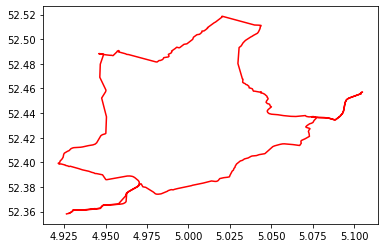

In [9]:
# Get Activity info
#athlete_id = strava_tokens['athlete']['id']
#url = "https://www.strava.com/api/v3/athletes/{}/routes".format(athlete_id)
url = "https://www.strava.com/api/v3/activities/4074378152"
access_token = strava_tokens['access_token']

# Get first page of activities from Strava with all fields
r = requests.get(url + '?access_token=' + access_token)
r = r.json()

summary_polyline_route = r['map']['summary_polyline']
plot_polyline(summary_polyline_route)

df_segments = pd.json_normalize(r['segment_efforts'])

In [10]:
# get how many segments in activity
df_segments.shape

(64, 42)

In [12]:
def calculate_time_difference_from_leader(segment_id, athlete_elapsed_time,
                                          gender, strava_tokens):
    """
    Gets the time of the segment's leader in seconds and calculates 
    the percent difference from the anthlete time
    """
    
    def get_sec(time_str):
        """ Get Seconds from time """

        if time_str.find("s") == -1:
            try:
                h, m, s = time_str.split(':')
                return int(h) * 3600 + int(m) * 60 + int(s)
            except ValueError:
                m, s = time_str.split(':')
                return int(m) * 60 + int(s)
        else:
            return [int(s) for s in re.findall(r'-?\d+\.?\d*', time_str)][0]

    url = "https://www.strava.com/api/v3/segments/{}".format(segment_id)
    access_token = strava_tokens['access_token']

    # Get first page of activities from Strava with all fields
    r = requests.get(url + '?access_token=' + access_token)
    r = r.json()

    # get leader time
    leader_elapsed_time = get_sec(
        r['xoms']['qom']) if gender == 'women' else get_sec(r['xoms']['kom'])

    return athlete_elapsed_time / leader_elapsed_time - 1

In [13]:
%%time
df_segments["segment_time_delta"] = df_segments.apply(
    lambda x: calculate_time_difference_from_leader(x["segment.id"],
                                                    x["elapsed_time"],
                                                    gender="man",
                                                    strava_tokens=strava_tokens
                                                    ),
    axis=1)

CPU times: user 1.21 s, sys: 72.6 ms, total: 1.28 s
Wall time: 41.7 s


In [14]:
df_segments.sort_values(by=['segment_time_delta'])

,id,resource_state,name,elapsed_time,moving_time,start_date,start_date_local,distance,start_index,end_index,...,segment.end_latitude,segment.end_longitude,segment.climb_category,segment.city,segment.state,segment.country,segment.private,segment.hazardous,segment.starred,segment_time_delta
25,2741743541458943054,2,Marken-Zeedijk,236,236,2020-09-17T16:43:33Z,2020-09-17T18:43:33Z,3251.120,665,736,...,52.436378,5.077737,0,Marken,Noord-Holland,The Netherlands,False,False,True,0.077626
24,2741743541454182478,2,Marken until corner,188,188,2020-09-17T16:43:22Z,2020-09-17T18:43:22Z,2599.900,661,717,...,52.434574,5.088045,0,Marken,Noord-Holland,Netherlands,False,False,True,0.153374
40,2741743541459818574,2,Sterrati Purmerbos (midden) N-Z,164,164,2020-09-17T17:25:17Z,2020-09-17T19:25:17Z,1376.000,1278,1329,...,52.482653,4.982462,0,Purmerend,Noord-Holland,Netherlands,False,False,False,0.281250
41,2741743541458269262,2,"01,36 WesterwegxGroeneweg tot aan Linnaeuslaan...",154,154,2020-09-17T17:32:29Z,2020-09-17T19:32:29Z,1368.900,1354,1402,...,52.491081,4.956902,0,Purmerend,Noord-Holland,Netherlands,False,False,False,0.283333
38,2741743541458630734,2,Purmerbos van Baanstee tot Groeneweg (Noord Zuid),517,502,2020-09-17T17:19:47Z,2020-09-17T19:19:47Z,4118.600,1194,1335,...,52.481562,4.981213,0,Purmerend,Noord-Holland,Netherlands,False,False,False,0.289277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54,2741743541462941774,2,Plaatsnaambordje Amsterdam Sprint - 500m,35,35,2020-09-17T17:53:33Z,2020-09-17T19:53:33Z,344.500,1650,1659,...,52.411640,4.930025,0,Landsmeer,Noord-Holland,Netherlands,False,False,False,2.181818
6,2741743541449890894,2,afdaling Zuiderzeeweg Z > N,43,43,2020-09-17T16:07:54Z,2020-09-17T18:07:54Z,401.000,150,165,...,52.381741,4.970509,0,Amsterdam,None,Netherlands,False,False,False,4.375000
4,2741743541451335758,2,Schellingwouderbrug Oost-Noord,476,104,2020-09-17T16:00:35Z,2020-09-17T18:00:35Z,939.346,128,164,...,52.381526,4.970241,0,Amsterdam,Noord-Holland,The Netherlands,False,False,False,7.981132
3,2741743541450581070,2,Schellingwouderbrug van Zuid > Noord,446,74,2020-09-17T16:00:28Z,2020-09-17T18:00:28Z,626.600,127,150,...,52.378765,4.967428,0,Amsterdam,Noord-Holland,Netherlands,False,False,False,9.619048


In [15]:
activity_id = '4074378152'
segment_id = df_segments['id'][0]
url_segment = 'https://www.strava.com/activities/{}/segments/2741743541458943054'.format(
    activity_id, segment_id)

In [16]:
import webbrowser

webbrowser.open(url_segment)

True

Ideas:
 * plot map with segments coloured by proximity to KOM (interactive map?)
 * create app where to select activity to get the segments analysis. Be able to plot the segment or open it in the browser
 * create REST API Flask
 * ref for plotting segment_polylines https://knanne.github.io/notebooks/visualize_strava_data_in_python.html#Geographic-Data

In [52]:
#!pipenv install git+https://github.com/matplotlib/basemap.git

In [53]:
# previous step:
# $ brew install geos
# !pipenv install https://github.com/matplotlib/basemap/archive/master.zip

/Users/pvilar/.local/share/virtualenvs/Strava-analysis--HuFty86/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/pvilar/.local/share/virtualenvs/Strava-analysis--HuFty86/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=1564270.9620172689,4401598.726055895,1615017.0560379555,4446612.184939481&bboxSR=5520&imageSR=5520&size=1500,1330&dpi=96&format=png32&transparent=true&f=image


UnsupportedOperation: seek

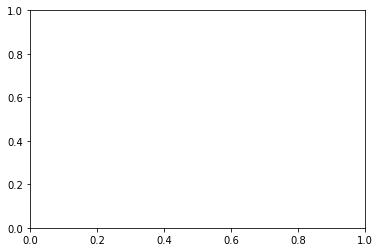

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

map = Basemap(llcrnrlon=3.75,llcrnrlat=39.75,urcrnrlon=4.35,urcrnrlat=40.15, epsg=5520)
#http://server.arcgisonline.com/arcgis/rest/services

map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
plt.show()

In [18]:
# opens a map in a new window
import requests
from PIL import Image
url ='http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_Imagery_World_2D/MapServer/export?bbox=1564270.9620172689,4401598.726055895,1615017.0560379555,4446612.184939481&bboxSR=5520&imageSR=5520&size=1500,1330&dpi=96&format=png32&transparent=true&f=image'
im = Image.open(requests.get(url, stream=True).raw)
im.show()

/Users/pvilar/.local/share/virtualenvs/Strava-analysis--HuFty86/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/pvilar/.local/share/virtualenvs/Strava-analysis--HuFty86/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))


http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/export?bbox=494623.2230448483,5798575.4150865255,498824.3666249413,5803229.983785062&bboxSR=23095&imageSR=23095&size=400,443&dpi=96&format=png32&transparent=true&f=image


UnsupportedOperation: seek

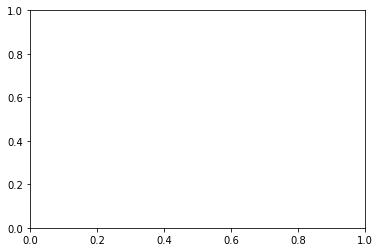

In [19]:
import polyline
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap

#summary_polyline = "ij_}Hyjd^dB_Gp@aAn@[F[{BwQpA?p@v@rCQf@m@_@iTSaAe\\cEWVKt@yANs@jCkAfB_JhIdEpP|ApD|BfDl@`DcEvCwEbCcHtKiGnLmKnOcClF{HxLoBrBgG~DmAnBy@pCYxBi@xIHlBu@xH{@tPu@fRLpIS~Eo@lC_HtOuJ|LwOrH{FrH}BdEoChBeBt@{HpBwBpBqA|Ba@K{DeGkKnQc@WkEwGsG~Aj@rBjBjWOhA}AtEc@`Ge\\rZyCbH{@|@Ij@r@hA|BxURf@E`@qJzQy_@fz@uGtG{Cy@}GxAyCrCqAfC{AfHmC|SQtEdAxHpBvGv@`EDbFm@pDo@r@sAl@qGc@}ALgJzIkGhNcDzOkBvHsCpD{EvCaGfBqWtC_FpB_F`FeOdV_HtEsJL{JeCqFaC}D}DkH{FyRiD_B}@cC`@{CyAeC`@}RrK_ErAcDnBuFJmBk@sA{@kAoBgD}Iw@_DK}DnAcBUsCTcIIsDkAkGu@eAiCiGyOoSoE{DqImDqE|@aG{AaH}CwDaD_DmFkCgMgB_GeEyFkV_LgE_AaI{BuARoDrBy@z@_BfDSBqCkLoBwFmBsBmDoAgCIkCxB}CtAsI?iFq@{B^cAYsAoBIcDcBkO}A{BuKcd@{Sq`AmAkH_@aFKuN^gFxAyHtPyj@fBcE|E}OzWk}@~CiHXgE`BoIv@wGj]_jE`AgBtAd@j_@j^bRdNn@|Ab@lFp@rAvJ|GxBr@^l@\\ANm@M_FJgu@l@mI`AsHfEeU`BsEjFcKxKoM|FwE~CcB`Cl@|DfH|CjGrInS`EzLnEjSrNb~@hHjc@jBnRzFv~@fCjf@jAn\\N|Ge@r}@L|Fj@t@tAXxPhBdeAkG`Du@M{DmHog@u@gDDiA`^cSdWmP|[e\\fDaE|HaGxB{D|FeO?e@_@u@sZue@YcBxOyl@nFiVtGqVnTir@r@gBd@e@VuCxCkJIgEfGyiAdAwZe@w@kQ{LYy@zDyWvDoRd@_A~zAfq@|q@l_@l@FnBaBfBe@fVvL`AxAt@tB^kEnBKlBf@~AhAr@`Av@zBtEeBfAyElAg@hGnA`B|@jBnBp@`AXbAAzDr@fCC`D`@lG\\NXfC`C`Fl@rBtGnc@Et@cA`Bn@`CyApDxBzD~@lCvCvBtEj]xBpKGp@aFnJ?b@~GpXdBdE~BnD|AxHxC~Dr@ItEdAzB_@"
summary_polyline = '_fq~Hy`d]f@qa@DkEHyClAyz@PoKRcBl@mBzCsI'

coordinates = polyline.decode(summary_polyline)

ride_longitudes = [coordinate[1] for coordinate in coordinates]
ride_latitudes = [coordinate[0] for coordinate in coordinates]

m = Basemap(
    llcrnrlon=min(ride_longitudes) - 0.02,
    llcrnrlat=min(ride_latitudes) - 0.02,
    urcrnrlon=max(ride_longitudes) + 0.02, 
    urcrnrlat=max(ride_latitudes) + 0.02,
    epsg=23095,
)

m.arcgisimage(service="World_Imagery", verbose=True)
x, y = m(ride_longitudes, ride_latitudes)
m.plot(x, y, 'r-')

plt.show()